<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Desafío 4: Luis Pablo Segovia
## LSTM Bot QA

## Importamos librerías para el Desafío

In [1]:
# Importamos librerías generales
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
import re
import seaborn as sns

from io import StringIO
from pathlib import Path

# De tensorflow y keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer, one_hot
from keras.utils import to_categorical, plot_model
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Dense, Flatten, LSTM, SimpleRNN
from tensorflow.keras.layers import Embedding

# De scikit-learn
from sklearn.model_selection import train_test_split

## Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 140MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [7]:
# Vemos un ejemplo de inputs y otro de outputs
print(f'Vemos como sería un input: {input_sentences[1]}')
print(f'Vemos un output: {output_sentences[1]}')
print(f'Vemos como tenemos el <sos> en el output: {output_sentences_inputs[1]}')

Vemos como sería un input: hi how are you 
Vemos un output: not bad and you  <eos>
Vemos como tenemos el <sos> en el output: <sos> not bad and you 


## Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [8]:
# Definimos las configuraciones recomendadas
MAX_VOCAB_SIZE = 8000
max_length = 10

In [9]:
# Generamos una instancia del tokenizador
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
# Fiteamos con los imputs
input_tokenizer.fit_on_texts(input_sentences)

### Entradas: preguntas

In [10]:
# Vemos el resultado de algunos pasarlos a secuencias
input_sequences = input_tokenizer.texts_to_sequences(input_sentences)
input_sequences[:10]

[[19],
 [11, 10, 7, 2],
 [11],
 [11],
 [11],
 [52, 7, 2, 359],
 [193],
 [52, 7, 2, 39],
 [1, 9, 39, 360, 38, 2],
 [1, 109, 134, 552, 41, 26, 170]]

In [11]:
# Generamos los indices de las preguntas
word2idx_input = input_tokenizer.word_index
# Imprimimos la longitud
print("Palabras en el vocabulario de las preguntas:", len(word2idx_input))

Palabras en el vocabulario de las preguntas: 1799


In [12]:
# Vemos cual es la longitud máxima de la entrada
max_input_len = max(len(sen) for sen in input_sequences)
print("Sentencia más larga de las preguntas:", max_input_len)

Sentencia más larga de las preguntas: 9


In [13]:
# Vemos la longitud de la sentencia de entrada
input_len = min(max_length, max_input_len)
print("Tamaño de sentencia de entrada:", input_len)

Tamaño de sentencia de entrada: 9


### Salidas: respuestas

In [14]:
# Generamos las respuestas
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='"#$%&()*+-./:;=¿@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)

In [15]:
# Vemos como son las respuetas tokenizadas
output_sequences = output_tokenizer.texts_to_sequences(output_sentences)
print(f'Secuencias de respuestas: {output_sequences[:5]}')
output_sequences_input = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print(f'Las salidas del input: {output_sequences_input[:5]}')

Secuencias de respuestas: [[25, 11, 8, 3, 1], [29, 192, 32, 3, 1], [21, 1], [21, 1], [21, 11, 8, 3, 43, 1]]
Las salidas del input: [[2, 25, 11, 8, 3], [2, 29, 192, 32, 3], [2, 21], [2, 21], [2, 21, 11, 8, 3, 43]]


- Se puede ver que tienen el **\<eos>** y **\<sos>** correspondiente.

In [16]:
# Generamos los índices de las respuetas
word2idx_output = output_tokenizer.word_index
# Contamos la cantidad
print("Palabras en el vocabulario en la salida:", len(word2idx_output))

Palabras en el vocabulario en la salida: 1806


In [17]:
# Vemos cual es la longitud máxima de las respuestas
max_output_len = max(len(sen) for sen in output_sequences)
print("Sentencia de salida más larga:", max_output_len)

# Tamaño de sentencia de salida
output_len = min(max_length, max_output_len)
print("Tamaño de sentencia de salida:", output_len)

Sentencia de salida más larga: 10
Tamaño de sentencia de salida: 10


In [18]:
# Conocemos la cantidad de filas del dataset
print("Cantidad de filas del dataset:", len(input_sequences))

Cantidad de filas del dataset: 6033


In [19]:
# Vemos el shape del encoder de secuencias de la entrada
encoder_input_sequences = pad_sequences(input_sequences, maxlen=input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

encoder_input_sequences shape: (6033, 9)


In [20]:
# Ahora vemos el decoder de las preguntas
decoder_input_sequences = pad_sequences(output_sequences_input, maxlen=output_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_input_sequences shape: (6033, 10)


In [21]:
# Calculamos el número de palabras en la salida
num_words_output = min(len(word2idx_output) + 1, MAX_VOCAB_SIZE)
print(f'Vemos la cantidad de palabras en las respuetas: {num_words_output}')

Vemos la cantidad de palabras en las respuetas: 1807


In [22]:
# Calculamos lo mismo pero para las respuetas
decoder_output_sequences = pad_sequences(output_sequences, maxlen=output_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print(f'Vemos el shape del target: {decoder_targets.shape}')

Vemos el shape del target: (6033, 10, 1807)


## Preparar los embeddings
Utilizar los embeddings de Glove para transformar los tokens de entrada en vectores

In [23]:
# Vamos a descargar los embeddings de Glove
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=b257ba88-c9b5-4ca2-9e12-3d3a8a5cfe98
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:04<00:00, 111MB/s]


In [24]:
# Generamos una clase que me permita manipularlos
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

In [25]:
# Generamos la clase para manipular un embedding de GloVe
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

In [26]:
# Generamos una instancia de la clase
model_embeddings = GloveEmbeddings()

In [27]:
# Definimos una función que genere la matriz de embeddings
def EmbeddingsMatrix(model, word2idx):
  embed_dim = model.N_FEATURES
  words_not_found = []

  nb_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
  embedding_matrix = np.zeros((nb_words, embed_dim))

  for word, i in word2idx.items():
      if i > nb_words:
          print('Se alcanzó la cantidad máxima de palabras')
          break

      embedding_vector = model_embeddings.get_words_embeddings(word)[0]
      if (embedding_vector is not None) and len(embedding_vector) > 0:
          embedding_matrix[i] = embedding_vector
      else:
          # words not found in embedding index will be all-zeros.
          words_not_found.append(word)

  print('Palabras no encontradas', words_not_found)
  print('Cantidad de embeddings nulos:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))
  print('Shape de la matriz de embeddings:', embedding_matrix.shape)

  return embedding_matrix

In [28]:
# Generamos con esta función las matrices de embeddings de input y output
encoder_embedding_matrix = EmbeddingsMatrix(model_embeddings, word2idx_input)

Palabras no encontradas []
Cantidad de embeddings nulos: 38
Shape de la matriz de embeddings: (1800, 50)


In [29]:
# Generamos la matriz del output
decoder_embedding_matrix = EmbeddingsMatrix(model_embeddings, word2idx_output)

Palabras no encontradas []
Cantidad de embeddings nulos: 42
Shape de la matriz de embeddings: (1807, 50)


## Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [30]:
# Definimos los parámetros de configuración
nb_words_input = min(MAX_VOCAB_SIZE, len(word2idx_input) + 1)
nb_words_output = min(MAX_VOCAB_SIZE, len(word2idx_output) + 1)
n_units = 128
dropout_p = 0.3
layer2_n_units = 32

### Encoder

In [31]:
# Definición de las capas
# Input
encoder_inputs = Input(shape=(input_len))

# Embedding
encoder_embedding_layer = Embedding(
          input_dim=nb_words_input,
          output_dim=model_embeddings.N_FEATURES,
          input_length=input_len,
          weights=[encoder_embedding_matrix],
          trainable=False)

# Bloque LSTM
encoder_lstm_1 = LSTM(n_units, return_sequences=True, return_state=True)
encoder_dropout_1 = Dropout(dropout_p)
encoder_lstm_2 = LSTM(layer2_n_units, return_state=True)

# Conexión entre las de capas
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)
encoder_output_lstm1, state_h_1, state_c_1 = encoder_lstm_1(encoder_inputs_x)
_, state_h_2, state_c_2 = encoder_lstm_2(encoder_dropout_1(encoder_output_lstm1))

# Generación de states
encoder_states_l1 = [state_h_1, state_c_1]
encoder_states_l2 = [state_h_2, state_c_2]
encoder_states = encoder_states_l1 + encoder_states_l2

### Decoder

In [32]:
# Definición de las capas
# Input
decoder_inputs = Input(shape=(output_len))

# Embedding
decoder_embedding_layer = Embedding(
          input_dim=nb_words_output,
          output_dim=model_embeddings.N_FEATURES,
          input_length=output_len,
          weights=[decoder_embedding_matrix],
          trainable=False)

# Bloque LSTM
decoder_lstm_1 = LSTM(n_units, return_sequences=True, return_state=True)
decoder_dopout_1 = Dropout(dropout_p)
decoder_lstm_2 = LSTM(layer2_n_units, return_sequences=True, return_state=True)

# Capa densa o fully connected
decoder_dense = Dense(num_words_output, activation='softmax')

# Conexión entre las de capas
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
decoder_lstm_1_output, _, _ = decoder_lstm_1(decoder_inputs_x, initial_state=encoder_states_l1)
decoder_lstm_2_output, _, _ = decoder_lstm_2(decoder_dopout_1(decoder_lstm_1_output), initial_state=encoder_states_l2)
decoder_outputs = decoder_dense(decoder_lstm_2_output)

### Modelo completo

In [33]:
# Generamos
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

# Obtenemos el summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 9, 50)                90000     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 10, 50)               90350     ['input_2[0][0]']             
                                                                                              

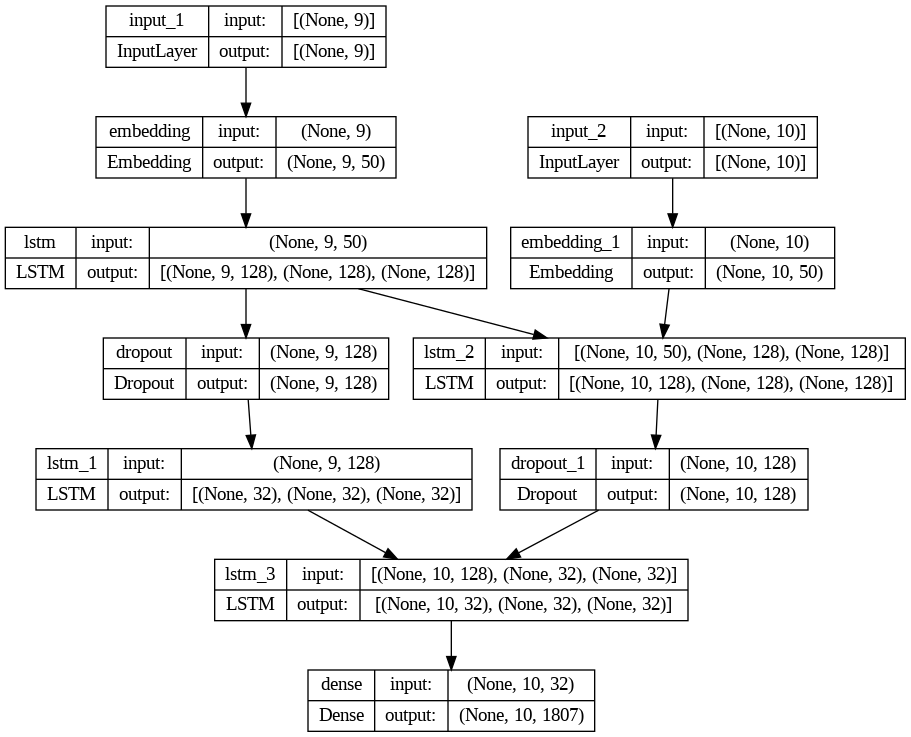

In [34]:
# Ploteamos el modelo
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

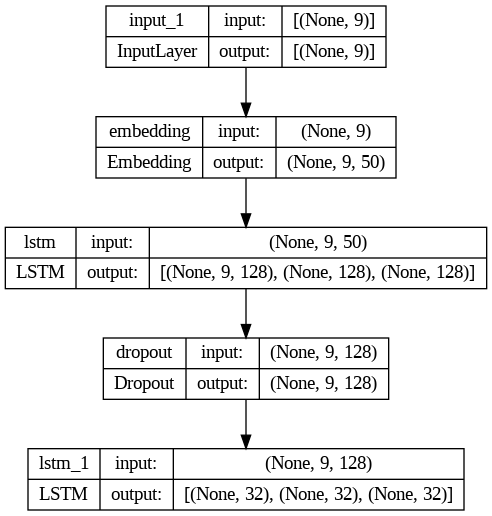

In [35]:
# Vemos el encoder
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

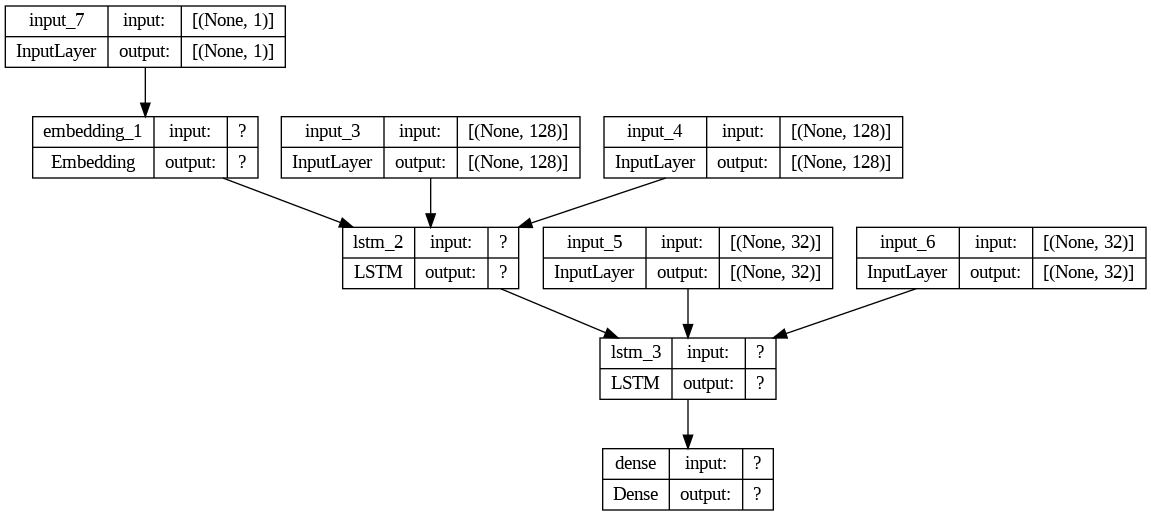

In [36]:
# Vemos ahora el decoder
decoder_state_input_h_1 = Input(shape=(n_units,))
decoder_state_input_c_1 = Input(shape=(n_units,))
decoder_state_input_h_2 = Input(shape=(layer2_n_units,))
decoder_state_input_c_2 = Input(shape=(layer2_n_units,))
decoder_states_inputs_1 = [decoder_state_input_h_1, decoder_state_input_c_1]
decoder_states_inputs_2 = [decoder_state_input_h_2, decoder_state_input_c_2]
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)
decoder_lstm_1_output, state_h_1, state_c_1 = decoder_lstm_1(decoder_inputs_single_x, initial_state=decoder_states_inputs_1)
decoder_lstm_2_output, state_h_2, state_c_2 = decoder_lstm_2(decoder_lstm_1_output, initial_state=decoder_states_inputs_2)
decoder_states_1 = [state_h_1, state_c_1]
decoder_states_2 = [state_h_2, state_c_2]
decoder_outputs = decoder_dense(decoder_lstm_2_output)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs_1 + decoder_states_inputs_2,
 [decoder_outputs] + decoder_states_1 + decoder_states_2)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

### Generamos el entrenamiento del modelo

In [37]:
hist = model.fit([encoder_input_sequences, decoder_input_sequences],
                 decoder_targets, epochs=50, validation_split=0.25)

Epoch 1/50
142/142 [==============================] - 14s 27ms/step - loss: 4.4733 - accuracy: 0.4830 - val_loss: 2.9556 - val_accuracy: 0.5075
Epoch 2/50
142/142 [==============================] - 3s 19ms/step - loss: 2.7858 - accuracy: 0.4908 - val_loss: 2.6369 - val_accuracy: 0.5075
Epoch 3/50
142/142 [==============================] - 2s 14ms/step - loss: 2.4600 - accuracy: 0.5142 - val_loss: 2.3773 - val_accuracy: 0.5817
Epoch 4/50
142/142 [==============================] - 2s 12ms/step - loss: 2.2665 - accuracy: 0.6066 - val_loss: 2.2600 - val_accuracy: 0.6296
Epoch 5/50
142/142 [==============================] - 2s 13ms/step - loss: 2.1595 - accuracy: 0.6139 - val_loss: 2.1915 - val_accuracy: 0.6297
Epoch 6/50
142/142 [==============================] - 2s 13ms/step - loss: 2.0837 - accuracy: 0.6170 - val_loss: 2.1367 - val_accuracy: 0.6380
Epoch 7/50
142/142 [==============================] - 2s 17ms/step - loss: 2.0135 - accuracy: 0.6344 - val_loss: 2.0858 - val_accuracy: 0.649

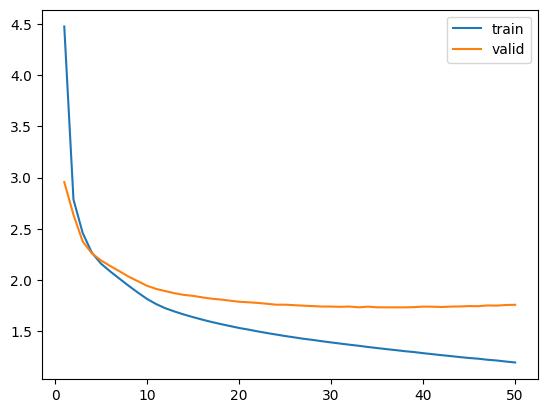

In [38]:
# Graficamos el historial del entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

## Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [39]:
# Generamos los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_input.items()}
idx2word_target = {v:k for k, v in word2idx_output.items()}

In [40]:
# Definimos una función que nos permita tener la respuesta:
def answer_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_output['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_output['<eos>']

    output_sentence = []
    for _ in range(output_len):
        # Predicción del próximo elemento
        output_tokens, h1, c1, h2, c2 = decoder_model.predict([target_seq] + states_value, verbose=0)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h1, c1, h2, c2]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [41]:
# Generamos una primera revisión
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answering = answer_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', answering)

-
Input: that would be awesome 
Response: i am a vegan


In [42]:
# Generamos una función que imprima la respuesta a nuestra pregunta:
def answer_bot(input):
  integer_seq_test = input_tokenizer.texts_to_sequences([input])[0]
  encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
  print(f'Question: {input}')
  print('A: ',answer_sentence(encoder_sequence_test))

In [43]:
# Listamos las frases que queremos que nos responda:
questions = [
    'How is the weather?',
    'Where is Argentina located?',
    'Where is the cat going?',
    'Is Music the answer?',
    'Is peanut butter good to health?'
]

In [44]:
# Generamos un loop de respuestas
for question in questions:
  answer_bot(question)

Question: How is the weather?
A:  what do you do for a living
Question: Where is Argentina located?
A:  i love to go to the beach
Question: Where is the cat going?
A:  i am a vegan
Question: Is Music the answer?
A:  what do you do for a living
Question: Is peanut butter good to health?
A:  what do you do for a living


## Conclusión
- Se tiene un buen nivel de coherencia en las respuestas pero no puede generar una respuesta directa.
- Hay varias respuestas similares.
- Para poder mejorar el modelo haría falta poder consumir todo el dataset y todo el vocabulario, pero la cantidad de RAM no es suficiente.